In [20]:
import time
import math
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import statsmodels.api as sm
import scipy.stats as stats
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut, LeavePOut
from sklearn.metrics import f1_score, confusion_matrix, classification_report

### Data

In [21]:
df = pd.DataFrame(pd.read_csv("global.csv"))
display(df.shape)
df.head(3)

(56223, 127)

,name,year,vs0,PSLV_v2,PSLV_v3,PSLV_v4,PSLV_v5,PSLV_v6,PSLV_v7,PSLV_v8,...,O700_t24,CFLX_t24,CSST_t24,V20C_t24,E000_t24,DELV-12,date,hour,date-time,dvs24
0,EP011982,1982,25,546,-20.0,10.0,-28.0,22.0,-23.0,20.0,...,-50.0,56.0,293.0,77.0,3511.0,0.786585,20-05-1982,00:00:00,20-05-1982 00:00,5.004258
1,EP011982,1982,25,621,-15.0,10.0,-31.0,21.0,-21.0,19.0,...,-58.0,53.0,293.0,67.0,3503.0,0.786585,20-05-1982,06:00:00,20-05-1982 06:00,5.004258
2,EP011982,1982,25,567,-20.0,10.0,-21.0,18.0,-20.0,17.0,...,-7.0,69.0,293.0,64.0,3497.0,0.000000,20-05-1982,12:00:00,20-05-1982 12:00,5.004258


In [22]:
#dropping the unnecessary columns
df.drop(columns = ['date', 'hour', 'date-time'], axis = 1, inplace = True)
display(df.shape)
df.head(3)

(56223, 124)

,name,year,vs0,PSLV_v2,PSLV_v3,PSLV_v4,PSLV_v5,PSLV_v6,PSLV_v7,PSLV_v8,...,HE07_t24,HE05_t24,O500_t24,O700_t24,CFLX_t24,CSST_t24,V20C_t24,E000_t24,DELV-12,dvs24
0,EP011982,1982,25,546,-20.0,10.0,-28.0,22.0,-23.0,20.0,...,12.0,14.0,-67.0,-50.0,56.0,293.0,77.0,3511.0,0.786585,5.004258
1,EP011982,1982,25,621,-15.0,10.0,-31.0,21.0,-21.0,19.0,...,30.0,50.0,-69.0,-58.0,53.0,293.0,67.0,3503.0,0.786585,5.004258
2,EP011982,1982,25,567,-20.0,10.0,-21.0,18.0,-20.0,17.0,...,27.0,43.0,-11.0,-7.0,69.0,293.0,64.0,3497.0,0.000000,5.004258


In [23]:
#create a list of all features
# Target is dvs24
feat = df.columns.to_list()
len(feat)

124

In [24]:
# Select a basin to run the model

select_basin = str(input('Select ocean basin: '))

# Dictionary of cell range index of the basins
basins = {
    'Western Pacific': '26616:44660',
    'Atlantic': '44660:55370',
    'Indian': '13399:15778',
    'Eastern Pacific': '0:13397'
}

if select_basin not in basins:
    raise ValueError("Invalid basin selection!")

# Extracting start and end indices from the dictionary based on the selected basin
start_idx, end_idx = map(int, basins[select_basin].split(':'))

Select ocean basin: Indian


In [25]:
df1 = df.iloc[start_idx : end_idx][feat]
print("Selected basin:", select_basin)
df1.head()

Selected basin: Indian


,name,year,vs0,PSLV_v2,PSLV_v3,PSLV_v4,PSLV_v5,PSLV_v6,PSLV_v7,PSLV_v8,...,HE07_t24,HE05_t24,O500_t24,O700_t24,CFLX_t24,CSST_t24,V20C_t24,E000_t24,DELV-12,dvs24
13399,IO021990,1990,30,476,-25.0,5.0,-10.0,8.0,-14.0,6.0,...,-12.0,-20.0,-143.0,-116.0,52.0,300.0,67.0,3564.0,5.004258,15.012775
13400,IO021990,1990,35,484,-28.0,15.0,-13.0,6.0,-17.0,8.0,...,-19.0,-17.0,-170.0,-150.0,23.0,300.0,81.0,3571.0,10.008517,15.012775
13401,IO021990,1990,35,494,-23.0,18.0,-11.0,5.0,-15.0,10.0,...,-18.0,-11.0,-130.0,-101.0,-9.0,300.0,106.0,3582.0,5.004258,20.017033
13402,IO021990,1990,40,543,-18.0,13.0,-15.0,10.0,-15.0,11.0,...,-17.0,-16.0,-173.0,-144.0,48.0,301.0,85.0,3572.0,5.004258,20.017033
13403,IO021990,1990,45,556,-20.0,5.0,-16.0,13.0,-17.0,9.0,...,-3.0,-8.0,-160.0,-127.0,46.0,301.0,123.0,3564.0,10.008517,25.021292


In [26]:
display(f'Range of years: {df1["year"].min()} - {df1["year"].max()}')
display(df1.shape)

'Range of years: 1990 - 2017'

(2379, 124)

#### Loading the best beatures file! 

#### The file contains the top features obtained after running random forest ranking or permutation feature importance

In [31]:
best_feat = pd.read_csv('best_20_rf_indian.csv')  # change csv file name here
best_feat = list(best_feat.iloc[:, 1].values)
best_feat += ['dvs24']    # appending the target label
best_feat

['DELV-12',
 'RSST_t24',
 'SHGC_t24',
 'SHDC_t24',
 'SHRD_t24',
 'vs0',
 'SHRG_t24',
 'VMPI_t24',
 'V300_t24',
 'MTPW_v10',
 'DTL_t24',
 'U200_t24',
 'TWXC_t24',
 'CSST_t24',
 'ENEG_t24',
 'TWAC_t24',
 'SHTS_t24',
 'MTPW_v18',
 'E000_t24',
 'U20C_t24',
 'dvs24']

In [32]:
# list of input features + target (use this variable in place of best_feat IF you want to use all 121 features)
all_feat = feat[2 :]

### Leave-three-year-out cross validation folds 

In [33]:
years = df1['year'].unique()  # Get unique years from the 'year' column

train_test_data = []  # List to store training and testing datasets

for i in range(0, len(years) - 2, 3):  # Loop over the range up to len(years) - 2
    test_years = years[i : i + 3]      # Three consecutive years as testing years
    train_years = np.setdiff1d(years, test_years)  # All other years as training years

    train_data = df1[df1['year'].isin(train_years)]  # Training data 
    test_data = df1[df1['year'].isin(test_years)]    # Testing data             

    train_data = train_data.drop(['name', 'year'], axis = 1)  
    test_data = test_data.drop(['name', 'year'], axis = 1)
    
    train_test_data.append((train_data, test_data))

### Statistical data analysis (descriptive statistics) of folds

In [34]:
years = df1['year'].unique()
total_stats = []

for i in range(0, len(years) - 2, 3):
    fold_years = years[i : i + 3]
    fold_data = df1[df1['year'].isin(fold_years)][best_feat]
    fold_stats = fold_data.describe().transpose()
    total_stats.append(fold_stats)  


features_of_interest = ['SHRG_t24', 'RSST_t24', 'V300_t24']  
fold_dfs = []

for i, stats in enumerate(total_stats, start = 1):
    filtered_stats = stats.loc[features_of_interest]
    filtered_stats['Fold'] = i
    fold_dfs.append(filtered_stats)
    print(f'FOLD #{i} \n {filtered_stats}')
    print()

all_folds_df = pd.concat(fold_dfs, axis = 1)  
all_folds_df.reset_index(inplace = True)

# Optional: Rename the index column if needed
all_folds_df.rename(columns = {'index': 'Statistic'}, inplace = True)

FOLD #1 
           count        mean         std    min     25%         50%    75%  \
SHRG_t24  292.0  274.557395  101.186202  110.0  197.25  255.523574  340.0   
RSST_t24  292.0  289.397405   11.127252  244.0  284.00  289.000000  297.0   
V300_t24  292.0    9.226666   34.956949 -100.0  -12.25    7.000000   29.0   

            max  Fold  
SHRG_t24  611.0     1  
RSST_t24  308.0     1  
V300_t24  118.0     1  

FOLD #2 
           count        mean         std    min    25%    50%    75%    max  \
SHRG_t24  183.0  275.215176  126.774045   85.0  196.5  254.0  308.5  901.0   
RSST_t24  183.0  285.771821    7.490892  258.0  282.0  286.0  291.0  301.0   
V300_t24  183.0    0.055134   30.941577 -109.0  -19.0    8.0   20.0   66.0   

          Fold  
SHRG_t24     2  
RSST_t24     2  
V300_t24     2  

FOLD #3 
           count        mean        std    min    25%    50%    75%    max  \
SHRG_t24  395.0  289.507165  79.208854  105.0  239.0  281.0  340.5  536.0   
RSST_t24  395.0  288.399906 

### Correlation of selected features in the last fold of data

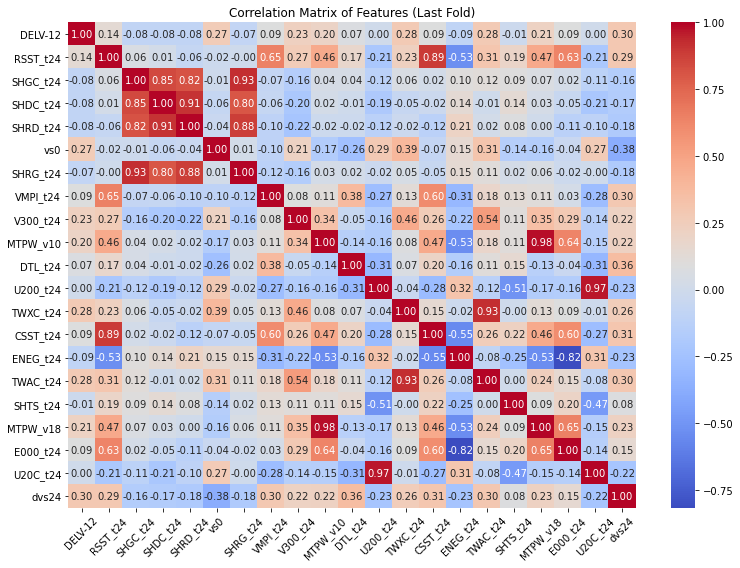

In [35]:
# Extract features from test_data
features = df1[best_feat].values

correlation_matrix = np.corrcoef(features, rowvar = False)

plt.figure(figsize = (11, 8))
sns.heatmap(correlation_matrix, annot = True,
            cmap = 'coolwarm', fmt = ".2f",
            xticklabels = best_feat, yticklabels = best_feat)
plt.title('Correlation Matrix of Features (Last Fold)')
plt.xticks(rotation = 45)
plt.yticks(rotation = 0)
plt.tight_layout()
plt.show()

### Removing correlated features (optional) 

In [36]:
threshold = 0.5
indices_to_remove = np.where(np.abs(correlation_matrix) > threshold)     
print(indices_to_remove)
indices_to_remove = [(i, j) for i, j in zip(indices_to_remove[0], indices_to_remove[1]) if i < j]

# Collect indices of features to remove
features_to_remove = set()
for i, j in indices_to_remove:
    if i not in features_to_remove: 
        features_to_remove.add(j)

# Create a new feature list without the removed features
truncated_best_feat = [feature for i, feature in enumerate(best_feat) if i not in features_to_remove]
print("Features after removing highly correlated features:", truncated_best_feat)

(array([ 0,  1,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  3,  4,  4,  4,
        4,  5,  6,  6,  6,  6,  7,  7,  7,  8,  8,  9,  9,  9,  9, 10, 11,
       11, 11, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 15, 15,
       15, 16, 16, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 19, 19, 20],
      dtype=int64), array([ 0,  1,  7, 13, 14, 18,  2,  3,  4,  6,  2,  3,  4,  6,  2,  3,  4,
        6,  5,  2,  3,  4,  6,  1,  7, 13,  8, 15,  9, 14, 17, 18, 10, 11,
       16, 19, 12, 15,  1,  7, 13, 14, 18,  1,  9, 13, 14, 17, 18,  8, 12,
       15, 11, 16,  9, 14, 17, 18,  1,  9, 13, 14, 17, 18, 11, 19, 20],
      dtype=int64))
Features after removing highly correlated features: ['DELV-12', 'RSST_t24', 'SHGC_t24', 'vs0', 'V300_t24', 'MTPW_v10', 'DTL_t24', 'U200_t24', 'TWXC_t24', 'dvs24']


In [37]:
threshold = 0.5
indices_to_remove = np.where(np.abs(correlation_matrix) > threshold)     
indices_to_remove = [(i, j) for i, j in zip(indices_to_remove[0], indices_to_remove[1]) if i < j]

# Collect indices of features to remove
features_to_remove = set()
for i, j in indices_to_remove:
    features_to_remove.add(j)

# Create a new feature list without the removed features
truncated_best_feat = [feature for i, feature in enumerate(best_feat) if i not in features_to_remove]
print("Features after removing highly correlated features:", truncated_best_feat)


Features after removing highly correlated features: ['DELV-12', 'RSST_t24', 'SHGC_t24', 'vs0', 'V300_t24', 'MTPW_v10', 'DTL_t24', 'U200_t24', 'TWXC_t24', 'dvs24']


In [38]:
len(truncated_best_feat)

10

### Correlation matrix after removing correlated features

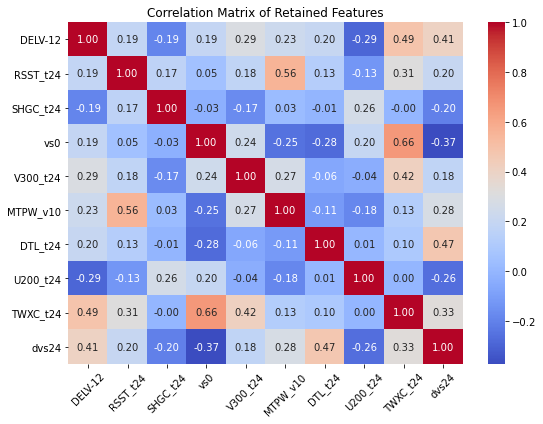

In [39]:
# Assuming train_test_data is a list of tuples where each tuple contains (train_data, test_data)
last_fold = train_test_data[-1]
train_data, test_data = last_fold

# Extract features from test_data
features = test_data[truncated_best_feat].values

# Calculate correlation matrix
correlation_matrix = np.corrcoef(features, rowvar = False)

# Plot heatmap
plt.figure(figsize = (8, 6))
sns.heatmap(correlation_matrix,
            annot = True, cmap = 'coolwarm',
            fmt = ".2f", xticklabels = truncated_best_feat,
            yticklabels = truncated_best_feat)
plt.title('Correlation Matrix of Retained Features')
plt.xticks(rotation = 45)
plt.yticks(rotation = 0)
plt.tight_layout()
plt.show()

## Model training and testing 
#### Change RI threshold (*`ri_threshold`*) as intended. 
#### Assign *`features_to_use`*  as either *`best_feat`* (to use selected features), *`truncated_best_feat`* (to use features with corr < 0.5) or *`all_feat`* to use all the 121 features. 

In [57]:
from sklearn.calibration import CalibratedClassifierCV

ri_threshold = 30
features_to_use = best_feat

list_f1, list_pod, list_far, list_hss, list_pss, list_bs  = [[] for _ in range(6)]

for i in range(len(train_test_data)):
    train_data, test_data = train_test_data[i]

    # Access the training and testing datasets for the current iteration
    X_train_initial = train_data[features_to_use].values     
    X_train = np.delete(X_train_initial, list(features_to_use).index('dvs24'), axis = 1)  
    y_train = train_data['dvs24'].values  

    X_test_initial = test_data[features_to_use].values    
    X_test = np.delete(X_test_initial, list(features_to_use).index('dvs24'), axis = 1)
    y_test = test_data['dvs24'].values
    
    #FEATURE SCALING AND TARGET ENCODING
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)         # input data scaling
    y_train = np.where(y_train >= ri_threshold, 1, 0)      # target feature (dvs24) encoding to 0 and 1

    unri = np.where(y_train < 1)
    ri = np.where(y_train > 0)
    a, b = y_train[unri], y_train[ri]

    X_test_scaled = scaler.fit_transform(X_test)           # input test data scaling
    y_test = np.where(y_test >= ri_threshold, 1, 0)        # target label encoding


    # SMOTE 
    sm = SMOTE(random_state = 42, k_neighbors = 10, sampling_strategy = {0: len(a), 1: round(0.60 * len(a))})                          
    xs, ys = sm.fit_resample(X_train_scaled, y_train)

    # SVC 
    if select_basin == 'Atlantic':
        svc = SVC(kernel = 'rbf', gamma = 0.001, C = 15, verbose = False)
    elif select_basin == 'Indian':
        svc = SVC(kernel = 'rbf', gamma = 0.0005, C = 5, verbose = False)
        
    classifier = svc.fit(xs, ys)
      
    # GETTING PROBABILITIES BY SVC
    calibrated_classifier = CalibratedClassifierCV(classifier, method = 'sigmoid', cv = 'prefit') # Calibration using Platt scaling
    calibrated_classifier.fit(xs, ys)
    probabilities = calibrated_classifier.predict_proba(X_test_scaled)[:, 1]     # Obtain calibrated probabilities
    rounded_probabilities = np.round(probabilities, 3)
    ypredict = (probabilities >= 0.5).astype(int)     # Threshold probabilities to get binary predictions
    
    # OUTPUT METRICS
    f1 = f1_score(y_test, ypredict, zero_division = 0)    # Calculate F1 score with zero_division parameter
    cm = confusion_matrix(y_test, ypredict)
    tp, tn, fp, fn = cm[1, 1], cm[0, 0], cm[0, 1], cm[1, 0]
    pod = tp / (tp + fn)                                              
    far = fp / (tp + fp)
    pofd = fp / (fp + tn)
    hss = 2 * ((tp*tn) - (fn*fp)) / ((tp+fn)*(fn+tn)+(tp+fp)*(fp+tn))
    pss = pod - pofd
    o_i = np.array(y_test)
    f_i = np.array(rounded_probabilities)
    bs = (1 / len(o_i)) * np.sum((f_i - o_i) ** 2)

    list_f1.append(f1)
    list_pod.append(pod)
    list_far.append(far)
    list_hss.append(hss)
    list_pss.append(pss)
    list_bs.append(bs)
    
    print('\nFold',i + 1, 'F1:', f1, 'POD:', pod, 'FAR:', far, 'HSS:', hss, 'PSS:', pss, 'BS:', bs)


Fold 1 F1: 0.36 POD: 1.0 FAR: 0.7804878048780488 HSS: 0.32592699466166497 PSS: 0.8869257950530035 BS: 0.08643887671232876

Fold 2 F1: 0.4444444444444444 POD: 0.7142857142857143 FAR: 0.6774193548387096 HSS: 0.37898737613682637 PSS: 0.5900253592561285 BS: 0.09834270491803279

Fold 3 F1: 0.06818181818181819 POD: 0.16666666666666666 FAR: 0.9571428571428572 HSS: -0.004652605459057072 PSS: -0.011052166224580023 BS: 0.1441008683544304

Fold 4 F1: 0.5625 POD: 0.6923076923076923 FAR: 0.5263157894736842 HSS: 0.497907949790795 PSS: 0.5988497483824586 BS: 0.07245174583333333

Fold 5 F1: 0.27586206896551724 POD: 0.5714285714285714 FAR: 0.8181818181818182 HSS: 0.24413145539906103 PSS: 0.4982578397212543 BS: 0.07544665612648221

Fold 6 F1: 0.6 POD: 1.0 FAR: 0.5714285714285714 HSS: 0.5512572533849129 PSS: 0.8878504672897196 BS: 0.07774915517241379

Fold 7 F1: 0.4583333333333333 POD: 0.5238095238095238 FAR: 0.5925925925925926 HSS: 0.39316783365160196 PSS: 0.44340751375927256 BS: 0.08304763181818181

F

In [59]:
# Averaging the metrics over all folds 

new_list_pod = [item for item in list_pod if item is not None and not math.isnan(item)]
new_list_far = [item for item in list_far if item is not None and not math.isnan(item)]
new_list_hss = [item for item in list_hss if item is not None and not math.isnan(item)]
new_list_pss = [item for item in list_pss if item is not None and not math.isnan(item)]

print('Mean POD:', round(sum(new_list_pod) / len(new_list_pod), 3))    
print('Mean FAR:', round(sum(new_list_far) / len(new_list_far), 3))
print('Mean F1:', round(sum(list_f1) / len(list_f1), 3))
print('Mean HSS:', round(sum(list_hss) / len(list_hss), 3))
print('Mean PSS:', round(sum(list_pss) / len(list_pss), 3))

bss_ref = 0.19     # 0.19 is the BSS for the SHIPS-RII `Consensus` model (DeMaria)
avg_bs = round(sum(list_bs) / len(list_bs), 3)
print('Mean BS:', avg_bs)
print('Mean BSS:', round(1 - (avg_bs / bss_ref), 3))  

Mean POD: 0.715
Mean FAR: 0.713
Mean F1: 0.394
Mean HSS: 0.342
Mean PSS: 0.603
Mean BS: 0.09
Mean BSS: 0.526


### Re-evaluation for 95% confidence intervals

In [63]:
from scipy.stats import t

num_runs = 20
ri_threshold = 30
num_folds = len(train_test_data)

list_avg_f1, list_avg_pod, list_avg_far, list_avg_hss, list_avg_pss, list_avg_bs = [[] for _ in range(6)]

for run in range(num_runs):
    list_f1, list_pod, list_far, list_hss, list_pss, list_bs = [[] for _ in range(6)]

    for i in range(num_folds):
        train_data, test_data = train_test_data[i]

        # Access the training and testing datasets for the current iteration
        X_train_initial = train_data[features_to_use].values  
        X_train = np.delete(X_train_initial, list(features_to_use).index('dvs24'), axis = 1)  
        y_train = train_data['dvs24'].values  

        X_test_initial = test_data[features_to_use].values    
        X_test = np.delete(X_test_initial, list(features_to_use).index('dvs24'), axis = 1)   
        y_test = test_data['dvs24'].values

        # FEATURE SCALING AND TEARGET ENCODING
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)  
        y_train = np.where(y_train >= ri_threshold, 1, 0)  

        unri = np.where(y_train < 1)
        ri = np.where(y_train > 0)
        a, b = y_train[unri], y_train[ri]

        X_test_scaled = scaler.fit_transform(X_test)  
        y_test = np.where(y_test >= ri_threshold, 1, 0)


        # SMOTE (without random seed!)
        sm = SMOTE(k_neighbors = 10, sampling_strategy = {0: len(a), 1: round(0.60 * len(a))})                          
        xs, ys = sm.fit_resample(X_train_scaled, y_train)

        # SVC 
        if select_basin == 'Atlantic':
            svc = SVC(kernel = 'rbf', gamma = 0.001, C = 15, verbose = False)
        elif select_basin == 'Indian':
            svc = SVC(kernel = 'rbf', gamma = 0.0005, C = 5, verbose = False)
            
        classifier = svc.fit(xs, ys)
        
        # GETTING PROBABILITIES BY SVC
        calibrated_classifier = CalibratedClassifierCV(classifier, method = 'sigmoid', cv = 'prefit') 
        calibrated_classifier.fit(xs, ys)
        probabilities = calibrated_classifier.predict_proba(X_test_scaled)[:, 1]  
        rounded_probabilities = np.round(probabilities, 3)
        ypredict = (probabilities >= 0.5).astype(int)  

        # OUTPUT METRICS
        f1 = f1_score(y_test, ypredict, zero_division = 0) 
        cm = confusion_matrix(y_test, ypredict)
        
        tp, tn, fp, fn = cm[1, 1], cm[0, 0], cm[0, 1], cm[1, 0]
        pod = tp / (tp + fn)
        far = fp / (tp + fp)
        pofd = fp / (fp + tn)
        hss = 2 * ((tp*tn) - (fn*fp)) / ((tp+fn)*(fn+tn)+(tp+fp)*(fp+tn))
        pss = pod - pofd
        o_i = np.array(y_test)
        f_i = np.array(rounded_probabilities)
        bs = (1 / len(o_i)) * np.sum((f_i - o_i) ** 2)

        list_f1.append(f1)
        list_pod.append(pod)
        list_far.append(far)
        list_hss.append(hss)
        list_pss.append(pss)
        list_bs.append(bs)

    # Calculate averages for the current run
    avg_f1 = np.mean(list_f1)
    avg_pod = np.mean(list_pod)
    avg_far = np.mean(list_far)
    avg_hss = np.mean(list_hss)
    avg_pss = np.mean(list_pss)
    avg_bs = np.mean(list_bs)

    list_avg_f1.append(avg_f1)
    list_avg_pod.append(avg_pod)
    list_avg_far.append(avg_far)
    list_avg_hss.append(avg_hss)
    list_avg_pss.append(avg_pss)
    list_avg_bs.append(avg_bs)

    print(f'Run{run + 1} Avg F1: {round(avg_f1, 3)} Avg POD: {round(avg_pod, 3)} Avg FAR: {round(avg_far, 3)} Avg HSS {round(avg_hss, 3)} Avg PSS {round(avg_pss, 3)} Avg BS {round(avg_bs, 3)}')

Run1 Avg F1: 0.387 Avg POD: 0.71 Avg FAR: 0.72 Avg HSS 0.333 Avg PSS 0.594 Avg BS 0.092
Run2 Avg F1: 0.39 Avg POD: 0.711 Avg FAR: 0.717 Avg HSS 0.336 Avg PSS 0.598 Avg BS 0.092
Run3 Avg F1: 0.383 Avg POD: 0.717 Avg FAR: 0.726 Avg HSS 0.329 Avg PSS 0.599 Avg BS 0.092
Run4 Avg F1: 0.384 Avg POD: 0.7 Avg FAR: 0.721 Avg HSS 0.33 Avg PSS 0.588 Avg BS 0.091
Run5 Avg F1: 0.389 Avg POD: 0.71 Avg FAR: 0.716 Avg HSS 0.336 Avg PSS 0.597 Avg BS 0.091
Run6 Avg F1: 0.389 Avg POD: 0.717 Avg FAR: 0.719 Avg HSS 0.335 Avg PSS 0.602 Avg BS 0.092
Run7 Avg F1: 0.383 Avg POD: 0.704 Avg FAR: 0.724 Avg HSS 0.329 Avg PSS 0.589 Avg BS 0.093
Run8 Avg F1: 0.391 Avg POD: 0.711 Avg FAR: 0.717 Avg HSS 0.338 Avg PSS 0.597 Avg BS 0.092
Run9 Avg F1: 0.385 Avg POD: 0.711 Avg FAR: 0.723 Avg HSS 0.331 Avg PSS 0.596 Avg BS 0.092
Run10 Avg F1: 0.38 Avg POD: 0.705 Avg FAR: 0.726 Avg HSS 0.326 Avg PSS 0.589 Avg BS 0.092
Run11 Avg F1: 0.39 Avg POD: 0.71 Avg FAR: 0.716 Avg HSS 0.337 Avg PSS 0.596 Avg BS 0.092
Run12 Avg F1: 0.38

In [66]:
# CONFIDENCE INTERVALS COMPUTATION 

# Calculate overall averages
overall_avg_f1 = np.mean(list_avg_f1)
overall_avg_pod = np.mean(list_avg_pod)
overall_avg_far = np.mean(list_avg_far)
overall_avg_hss = np.mean(list_avg_hss)
overall_avg_pss = np.mean(list_avg_pss)
overall_avg_bs = np.mean(list_avg_bs)

# Calculate confidence intervals (95%) for overall averages
confidence = 0.95
n = num_runs
t_value = t.ppf((1 + confidence) / 2, n - 1)
ci_avg_f1 = t_value * np.std(list_avg_f1, ddof=1) / np.sqrt(n)
ci_avg_pod = t_value * np.std(list_avg_pod, ddof=1) / np.sqrt(n)
ci_avg_far = t_value * np.std(list_avg_far, ddof=1) / np.sqrt(n)
ci_avg_hss = t_value * np.std(list_avg_hss, ddof=1) / np.sqrt(n)
ci_avg_pss = t_value * np.std(list_avg_pss, ddof=1) / np.sqrt(n)
ci_avg_bs = t_value * np.std(list_avg_bs, ddof=1) / np.sqrt(n)

# Calculate the confidence interval as mean value plus/minus uncertainty
ci_avg_f1_interval = (overall_avg_f1 - ci_avg_f1, overall_avg_f1 + ci_avg_f1)
ci_avg_pod_interval = (overall_avg_pod - ci_avg_pod, overall_avg_pod + ci_avg_pod)
ci_avg_far_interval = (overall_avg_far - ci_avg_far, overall_avg_far + ci_avg_far)
ci_avg_hss_interval = (overall_avg_hss - ci_avg_hss, overall_avg_hss + ci_avg_hss)
ci_avg_pss_interval = (overall_avg_pss - ci_avg_pss, overall_avg_pss + ci_avg_pss)
ci_avg_bs_interval = (overall_avg_bs - ci_avg_bs, overall_avg_bs + ci_avg_bs)

# Print overall averages and confidence intervals
print('\nF1: {:.3f} ± {:.3f}'.format(overall_avg_f1, ci_avg_f1))
print('POD: {:.3f} ± {:.3f}'.format(overall_avg_pod, ci_avg_pod))
print('FAR: {:.3f} ± {:.3f}'.format(overall_avg_far, ci_avg_far))
print('HSS: {:.3f} ± {:.3f}'.format(overall_avg_hss, ci_avg_hss))
print('PSS: {:.3f} ± {:.3f}'.format(overall_avg_pss, ci_avg_pss))
print('BS: {:.3f} ± {:.3f}'.format(overall_avg_bs, ci_avg_bs))


F1: 0.386 ± 0.002
POD: 0.709 ± 0.003
FAR: 0.721 ± 0.002
HSS: 0.332 ± 0.002
PSS: 0.594 ± 0.003
BS: 0.092 ± 0.000
